# Multi-Class Prediction of Cirrhosis Outcomes


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## EDA

In [3]:
#read data
df = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv")

In [4]:
#show first 5 rows
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [5]:
#show data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [6]:
#check null values
df.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [7]:
#check duplicates
df.duplicated().sum()

0

In [8]:
#summary statistics for numerical columns
df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,3952.000000,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,2282.121272,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,0.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1976.000000,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,3952.000000,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,5928.000000,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,7904.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


In [9]:
#summary statistics for object columns
df.describe(include='object')

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
count,7905,7905,7905,7905,7905,7905,7905
unique,2,2,2,2,2,3,3
top,Placebo,F,N,Y,N,N,C
freq,4010,7336,7525,4042,5966,7161,4965


### Summary
- Dataset don't have null or dublicated values so no need for cleaning 
- Reasonable data types for the columns, we can replace object with category
- We can replace the 'Age' column to be in years insted of days for better visualizations

## Visualizations

<Axes: xlabel='Age', ylabel='Status'>

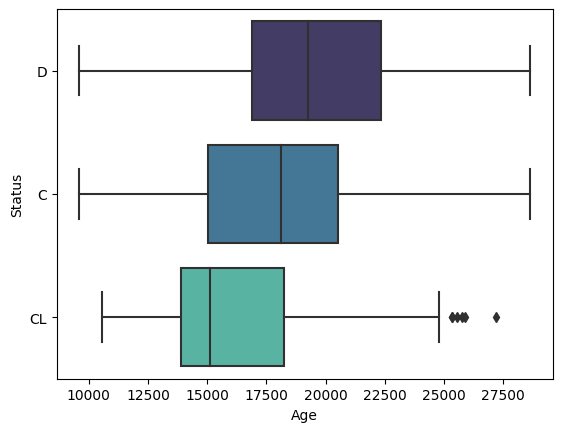

In [10]:
#df['Age'] = df['Age']/365
sns.boxplot(x='Age', data=df, y= 'Status', palette= 'mako')

<Axes: xlabel='Drug', ylabel='count'>

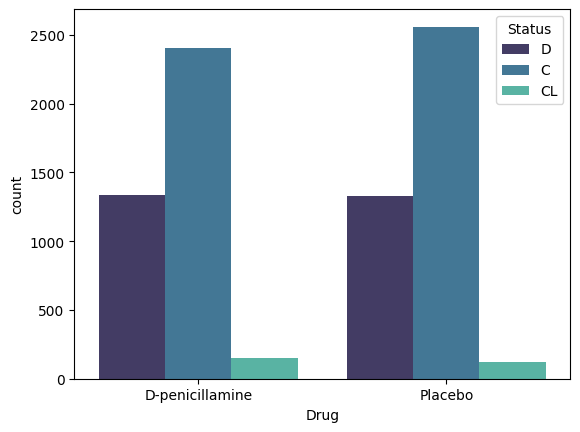

In [11]:
sns.countplot(x='Drug', data=df, hue= 'Status',palette= 'mako')

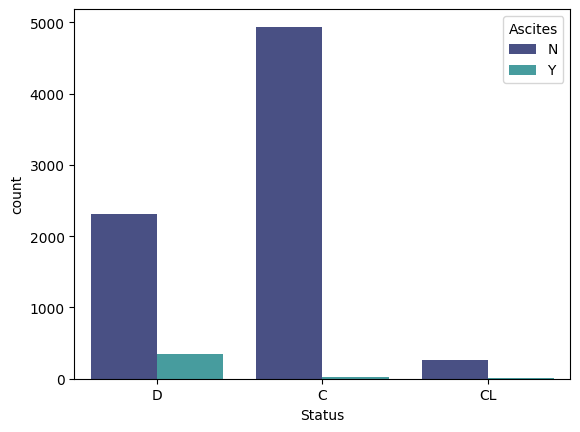

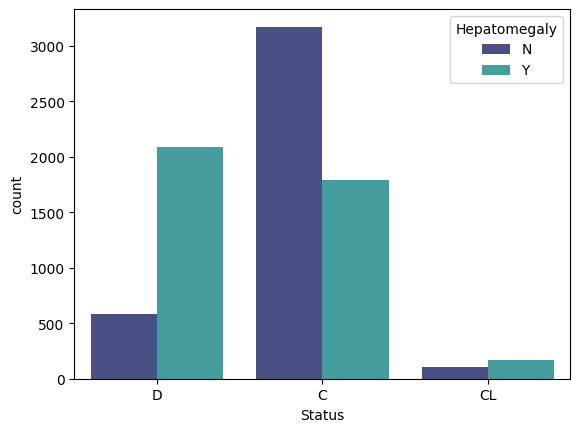

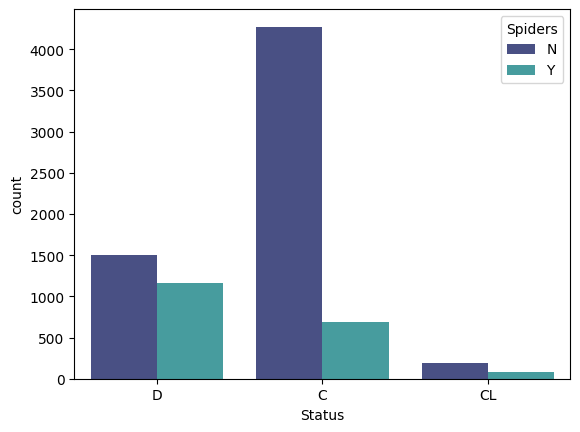

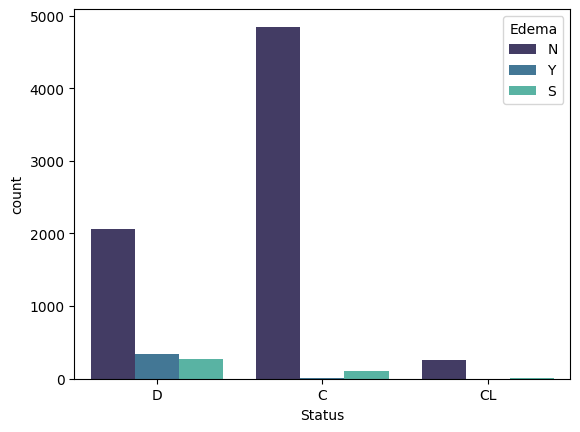

In [12]:
features = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
for i in features:
    sns.countplot(x='Status', data=df, hue=i, palette= 'mako')
    plt.show()

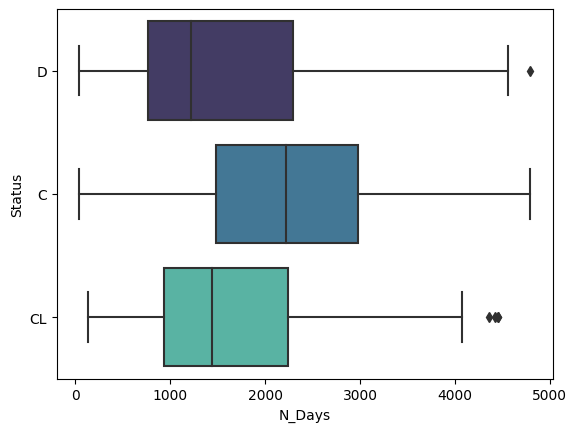

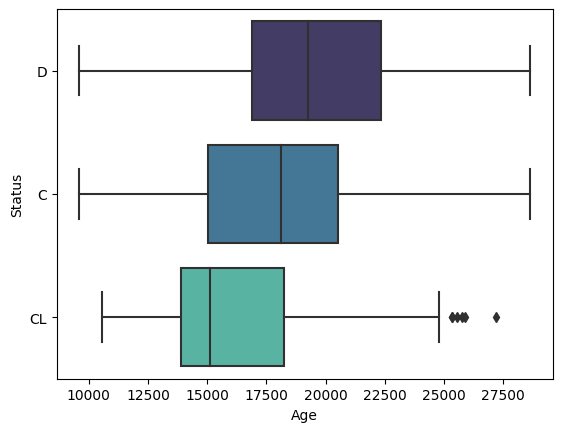

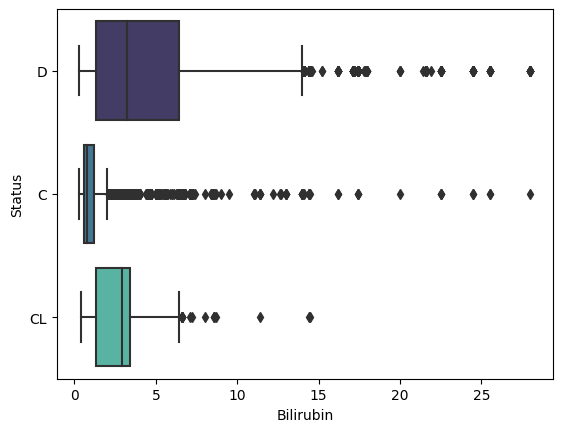

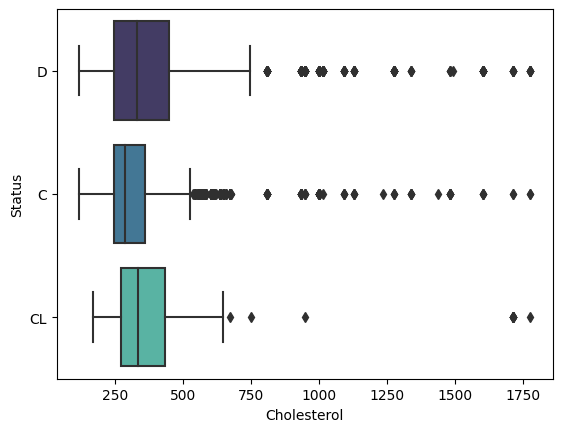

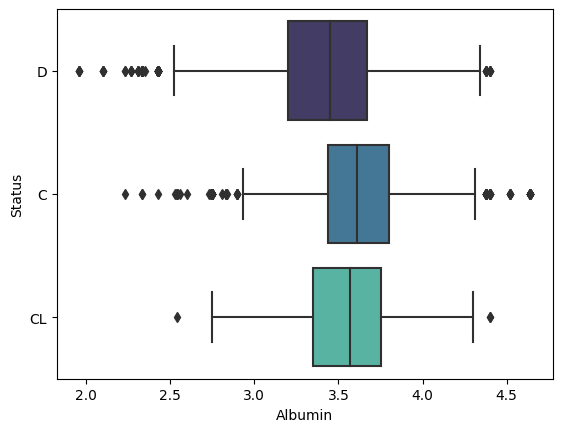

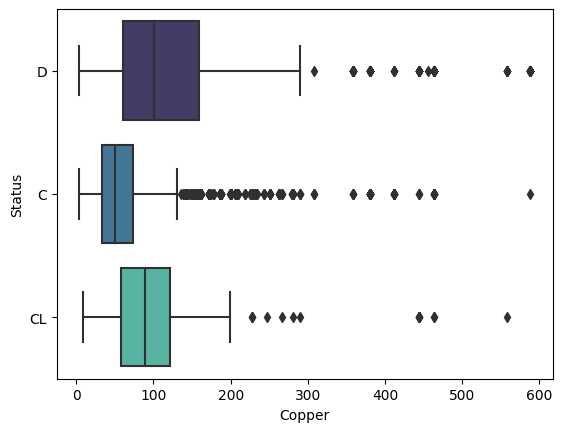

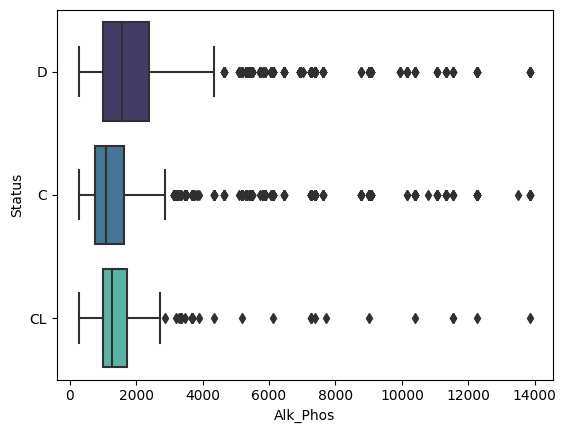

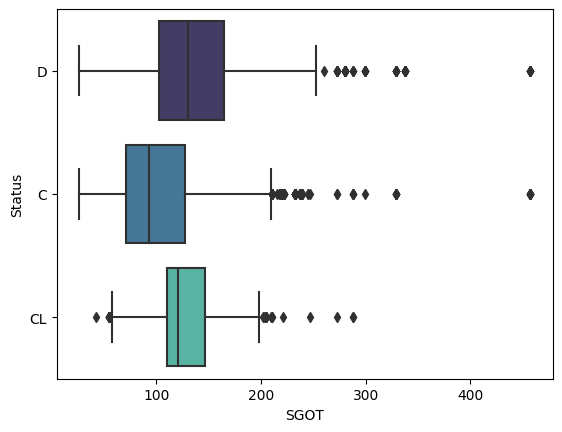

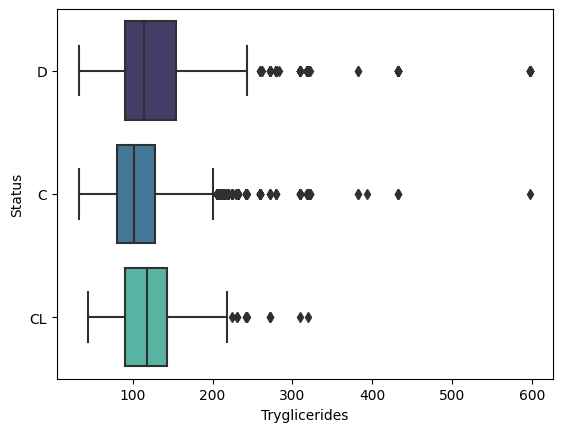

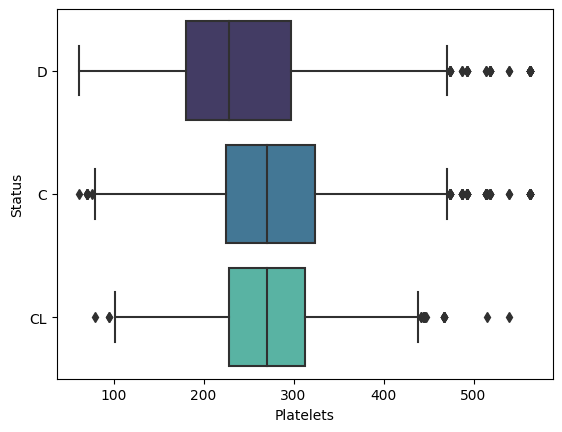

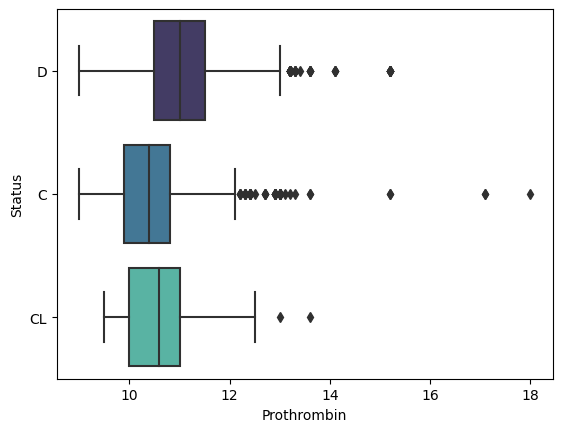

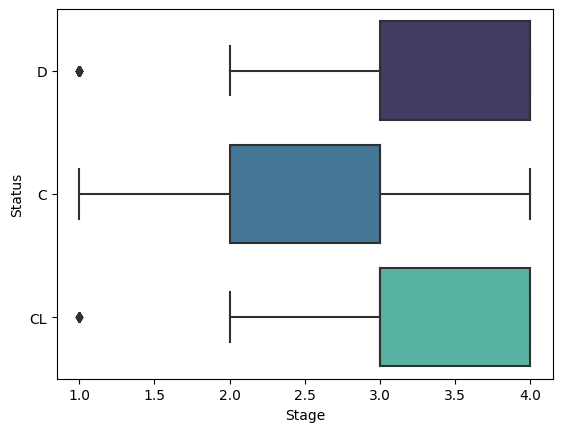

In [13]:
dff = df.drop('id', axis=1)
for col in dff.select_dtypes(np.number):
    sns.boxplot(x = col, y = 'Status', data = df, palette= 'mako')
    plt.show()

<Axes: xlabel='Status', ylabel='count'>

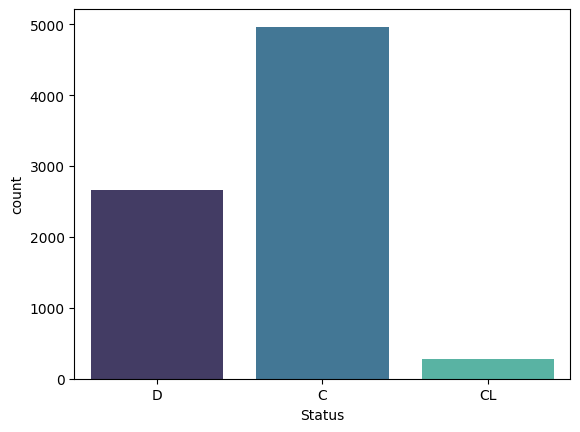

In [14]:
sns.countplot(x='Status', data=df, palette= 'mako')

## Summary:
- Younger people are more likely to have `liver transplant` and live 'CL'
- It seems like the 'Drug' `D-penicillamine` is not affective
- People with `Ascites` have high probability for death
- Large number of People with `Hepatomegaly` are alive so it may not be a main cause to death
- Dataset is `impalanced`

## Preprocessing & Machine learning

In [15]:
#Oversampling
ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=42) 

In [16]:
#encoders and pipelines
enc1 = OneHotEncoder()
enc2 = OrdinalEncoder()

cat1 = Pipeline([
    ("encoder", enc1)
])
cat2 = Pipeline([
    ("encoder", enc2)
])

cleaning = ColumnTransformer([
    ("cat", cat1,['Drug','Sex']),
    ("cat2", cat2, ['Ascites', 'Hepatomegaly', 'Spiders','Edema'])], remainder = 'passthrough')

cleaning_M = ColumnTransformer([
    ("cat2", cat2, ['Hepatomegaly', 'Spiders','Edema'])], remainder = 'passthrough')

In [17]:
X = df.drop('Status', axis=1)
y = df['Status']

In [18]:
#split the date to train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
#fit transform for the pipeline
X_train_e = cleaning.fit_transform(X_train)
X_val_e = cleaning.transform(X_val)

In [20]:
#apply random sampling
X_train_os, y_train_os = ros.fit_resample(X_train_e, y_train)

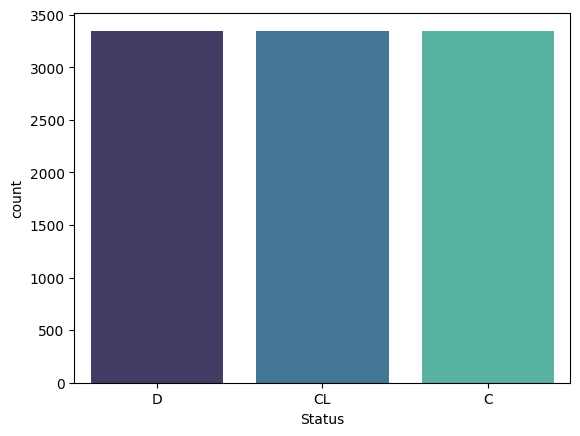

In [21]:
#done, data is palanced now
sns.countplot(x= y_train_os, palette= 'mako')
plt.show()

In [22]:
RF = RandomForestClassifier()

In [23]:
RF.fit(X_train_os, y_train_os)

RandomForestClassifier()

In [24]:
#using cross validation with 3 k-folds
y_train_pred = cross_val_predict(RF, X_train_os,y_train_os, cv=3)

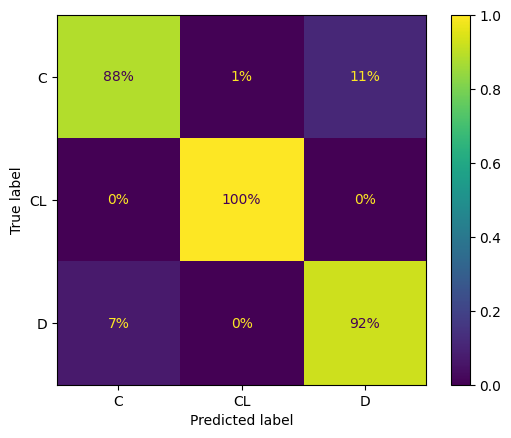

In [25]:
#Confusion matrix on train dataset
ConfusionMatrixDisplay.from_predictions(y_train_os, y_train_pred, normalize="true", values_format=".0%")
plt.show()

In [26]:
f1_score(y_train_os, y_train_pred, average = None)

array([0.90361998, 0.99568773, 0.90815728])

In [27]:
#Validation dataset
y_val_pred = RF.predict(X_val_e)

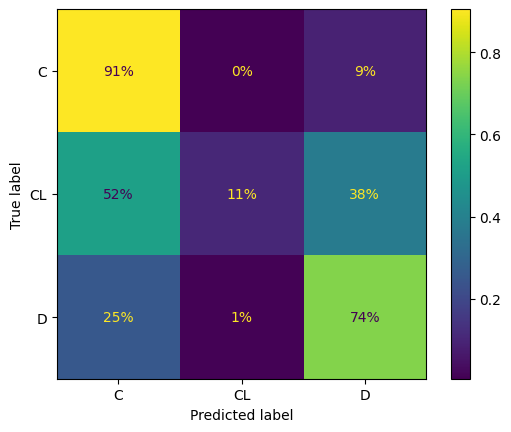

In [28]:
#Confusion matrix on validation dataset
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, normalize="true", values_format=".0%")
plt.show()

In [29]:
f1_score(y_val, y_val_pred, average = None)

array([0.87194759, 0.16528926, 0.76020702])

## Test Data

In [30]:
test_df_c = cleaning.transform(test_df)

In [31]:
test_predict_prob = RF.predict_proba(test_df_c)

## Sample submition

In [32]:
sub2 = test_df[['id']]
sub2[['Status_C', 'Status_CL', 'Status_D']] = test_predict_prob

In [33]:
sub2.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.55,0.04,0.41
1,7906,0.59,0.14,0.27
2,7907,0.24,0.03,0.73
3,7908,0.82,0.02,0.16
4,7909,0.63,0.12,0.25


In [34]:
sub2.to_csv('sub_2.csv', index = False)